Goal of Project: To create an AI system that can analyze x-ray images 

Variables: 

Types of Data in the dataset:
- jkl

Data Quality Issues / Limitations:
- 

Domain Specific Concerns:
- 

Notes:
- 112,120 X-ray images from 30,805 patient
- 14 different thorax diseases
- 25,596 sets of data
- tensor labels represent diseases
    - 14 labels
- Multiple data fields
- Data pre-split between training and test set
- viewposition represents anteroposterior (AP) and posteroanterior (PA)
- Outlier that is age 400? --> needs to be removed

In [ ]:
#imports
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter



In [96]:
#Load the Dataset
ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



\

hub://activeloop/nih-chest-xray-test loaded successfully.



In [97]:
#Get column names
print(ds.tensors.keys())

# Select findings images
tensor = ds['findings']

# Print tensor attributes
print("Data Type:", tensor.dtype)
print("High-Level Type:", tensor.htype)
print("Shape:", tensor.shape) # length dimension is none because the number of conditions per image is variable
print("Info:", tensor.info)


dict_keys(['images', 'findings', 'boxes/bbox', 'boxes/finding', 'metadata/patient_id', 'metadata/patient_age', 'metadata/patient_gender', 'metadata/follow_up_num', 'metadata/view_position', 'metadata/orig_img_w', 'metadata/orig_img_h', 'metadata/orig_img_pix_spacing_x', 'metadata/orig_img_pix_spacing_y'])
Data Type: uint32
High-Level Type: class_label
Shape: (25596, None)
Info: {'class_names': ['No Finding', 'Hernia', 'Emphysema', 'Nodule', 'Pneumonia', 'Consolidation', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening', 'Atelectasis', 'Pneumothorax', 'Fibrosis', 'Infiltration', 'Edema']}


In [98]:
# Load the patient IDs tensor
patient_ids = np.array([ds["metadata/patient_id"][i].numpy() for i in range(len(ds["metadata/patient_id"]))])

# Get the number of unique patient IDs
num_unique_patients = len(np.unique(patient_ids))
unique_patient_ids = np.unique(patient_ids)

# Print the number of unique patients
print(f"Number of unique patients: {num_unique_patients}")

print(f"Total Entries: {len(ds)}")  # Total number of entries

C:\Users\tajvi\AppData\Roaming\Python\Python313\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Number of unique patients: 2797
Total Entries: 25596


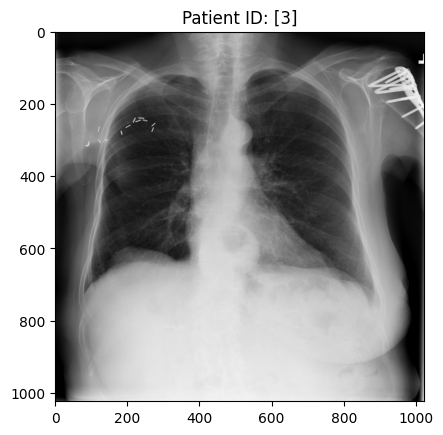

In [99]:
# Load first image and label
image = ds['images'][0].numpy()
id = ds['metadata/patient_id'][0].numpy()

# Display image
plt.imshow(image, cmap="gray")
plt.title(f"Patient ID: {id}")
plt.show()

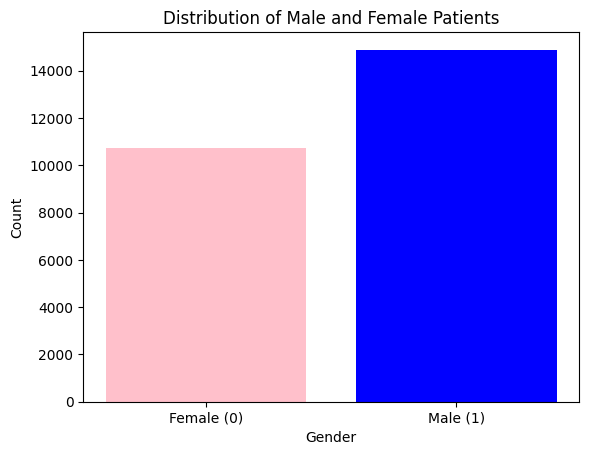

In [100]:
# Load patient gender tensor (0 = Female, 1 = Male)
genders = np.array([ds["metadata/patient_gender"][i].numpy() for i in range(len(ds["metadata/patient_gender"]))])

# Count occurrences of each gender
unique, counts = np.unique(genders, return_counts=True)

# Plot histogram
plt.bar(["Female (0)", "Male (1)"], counts, color=['pink', 'blue'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Male and Female Patients")
plt.show()

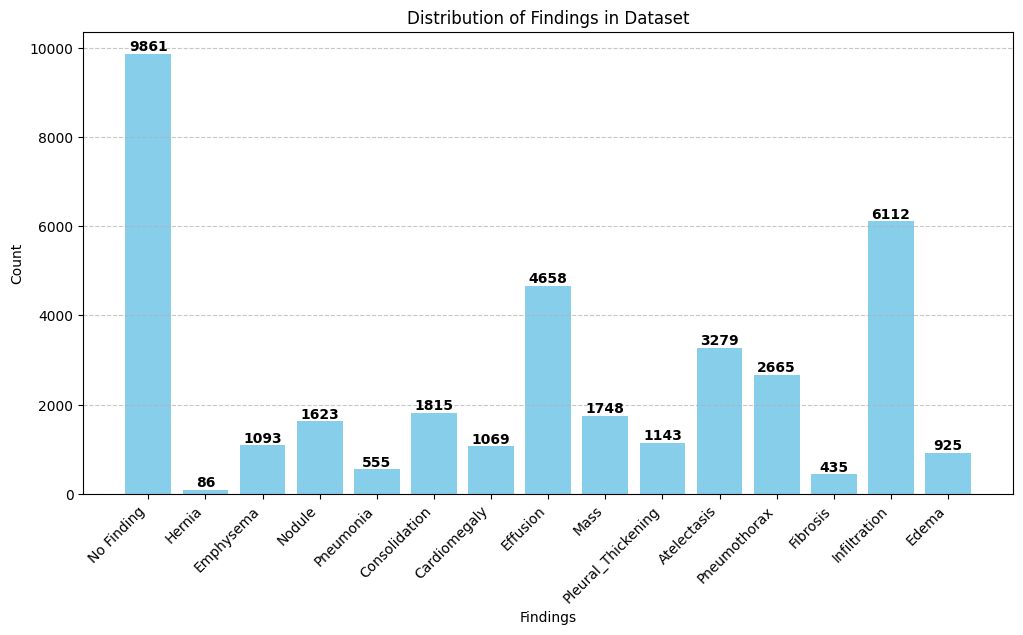

In [101]:
# Class names from dataset info
class_names = [
    "No Finding", "Hernia", "Emphysema", "Nodule", "Pneumonia", 
    "Consolidation", "Cardiomegaly", "Effusion", "Mass", 
    "Pleural_Thickening", "Atelectasis", "Pneumothorax", 
    "Fibrosis", "Infiltration", "Edema"
]

# Collect all findings (handling variable-length entries)
findings = []
for i in range(len(ds["findings"])):
    findings.extend(ds["findings"][i].numpy())  # Extend to flatten the list

# Convert to NumPy array
findings = np.array(findings)

# Count occurrences of each finding
unique, counts = np.unique(findings, return_counts=True)

# Plot histogram
plt.figure(figsize=(12, 6))
bars = plt.bar([class_names[i] for i in unique], counts, color='skyblue')

# Add counts on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
plt.xticks(rotation=45, ha="right")
plt.xlabel("Findings")
plt.ylabel("Count")
plt.title("Distribution of Findings in Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

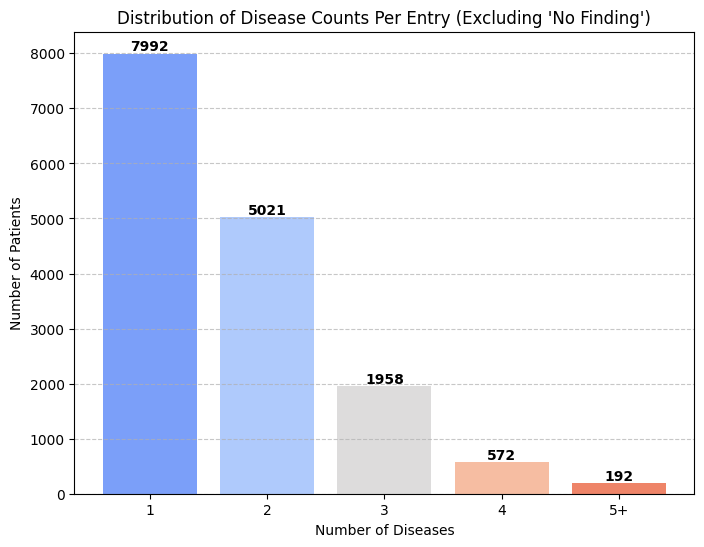

In [102]:
# Collect all findings per entry
disease_counts = []  # Stores the number of diseases per entry

for i in range(len(ds["findings"])):
    findings = ds["findings"][i].numpy()
    
    # Ignore "No Finding" (label 0)
    findings = [f for f in findings if f != 0]
    
    # Count number of diseases for this entry
    if findings:
        disease_counts.append(len(findings))

# Convert to NumPy array
disease_counts = np.array(disease_counts)

# Group counts (capping at 5+)
disease_bins = [1, 2, 3, 4, 5]  # Bins: 1, 2, 3, 4, 5+
labels = ["1", "2", "3", "4", "5+"]

# Count occurrences per bin
hist_counts = np.histogram(disease_counts, bins=[1, 2, 3, 4, 5, np.inf])[0]

# Use a colormap for color variation
colors = plt.get_cmap("coolwarm")(np.linspace(0.2, 0.8, len(hist_counts)))

# Plot histogram
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, hist_counts, color=colors)

# Add counts on top of bars
for bar, count in zip(bars, hist_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
             ha="center", va="bottom", fontsize=10, fontweight="bold")

# Formatting
plt.xlabel("Number of Diseases")
plt.ylabel("Number of Patients")
plt.title("Distribution of Disease Counts Per Entry (Excluding 'No Finding')")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


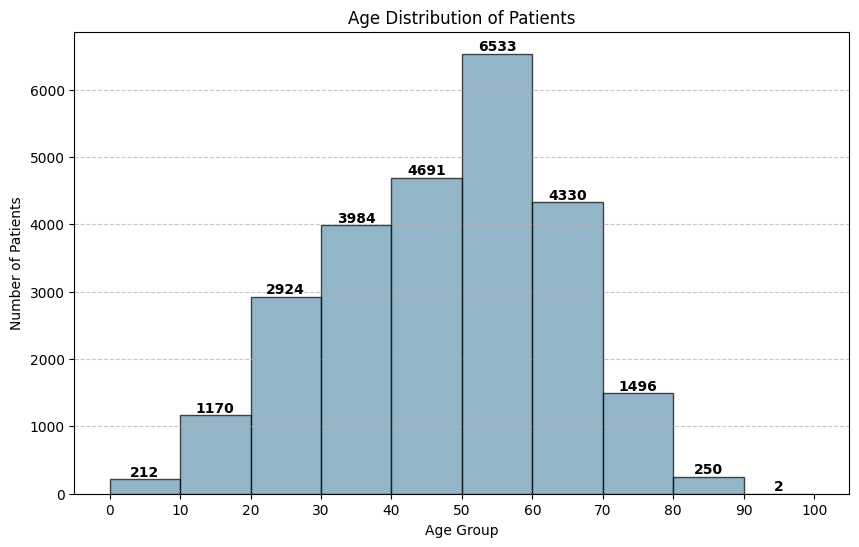

In [103]:


# Extract age data
ages = np.array([ds["metadata/patient_age"][i].numpy() for i in range(len(ds["metadata/patient_age"]))])

# Define bins (adjust if needed)
bins = range(0, 110, 10)  # Group ages in 10-year intervals

# Create histogram
plt.figure(figsize=(10, 6))
bars = plt.hist(ages, bins=bins, color="#6497b1", edgecolor="black", alpha=0.7)

# Add count labels on top of bars
for i in range(len(bars[0])):
    plt.text(bars[1][i] + 5, bars[0][i], str(int(bars[0][i])), 
             ha="center", va="bottom", fontsize=10, fontweight="bold")

# Formatting
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.title("Age Distribution of Patients")
plt.xticks(bins)  # Set x-axis ticks to match bin edges
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


Mean Age: 47.01
Median Age: 49.0
Age Standard Deviation: 16.85
Youngest Patient: 1
Oldest Patient: 414


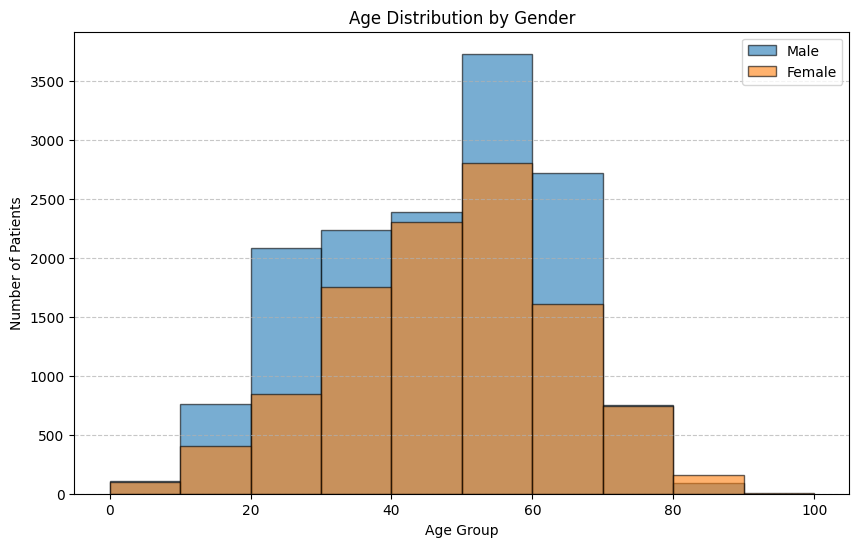

In [104]:
# ---- Age Statistics ----

# Extract age data
ages = np.array([ds["metadata/patient_age"][i].numpy() for i in range(len(ds["metadata/patient_age"]))])

# Compute basic statistics
mean_age = np.mean(ages)
median_age = np.median(ages)
std_age = np.std(ages)
min_age = np.min(ages)
max_age = np.max(ages)

print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Age Standard Deviation: {std_age:.2f}")
print(f"Youngest Patient: {min_age}")
print(f"Oldest Patient: {max_age}")

# Extract gender and age data
genders = np.array([ds["metadata/patient_gender"][i].numpy() for i in range(len(ds["metadata/patient_gender"]))])
ages_male = ages[genders == 1]  # Label 1 = Male
ages_female = ages[genders == 0]  # Label 0 = Female

# Plot age distribution per gender
plt.figure(figsize=(10, 6))
plt.hist(ages_male, bins=range(0, 110, 10), alpha=0.6, label="Male", color="#1f77b4", edgecolor="black")
plt.hist(ages_female, bins=range(0, 110, 10), alpha=0.6, label="Female", color="#ff7f0e", edgecolor="black")

# Formatting
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.title("Age Distribution by Gender")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


C:\Users\tajvi\AppData\Roaming\Python\Python313\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


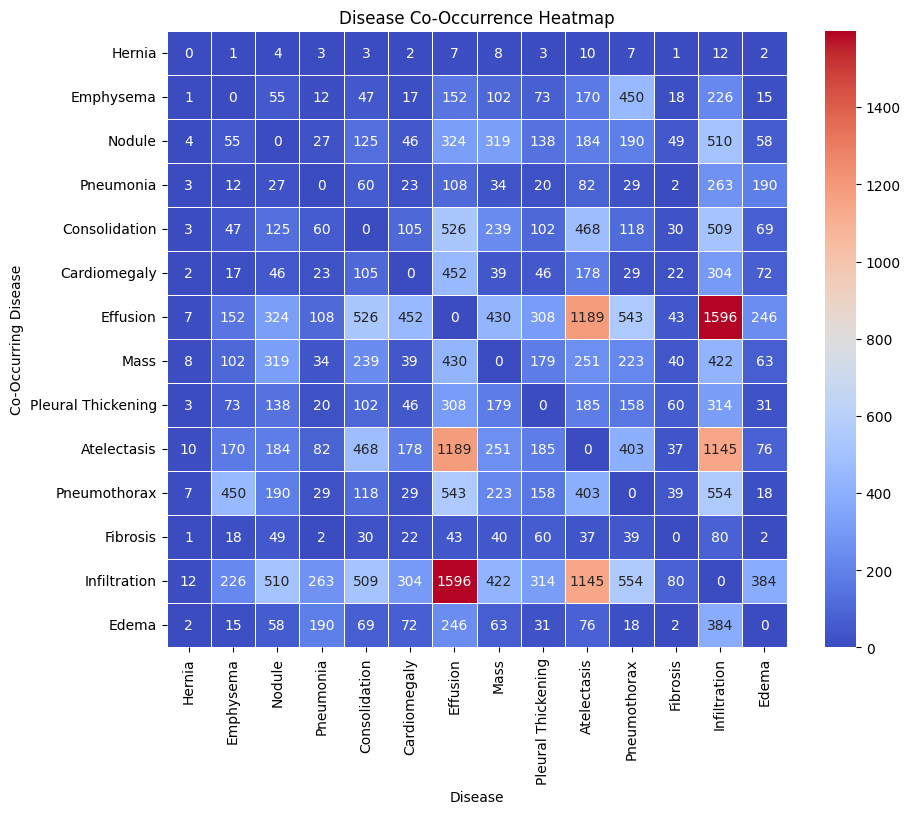

In [127]:
# ---- Concurrence of Diseases ----

num_diseases = 14  # 14 diseases (excluding "No Finding")
co_occurrence = np.zeros((num_diseases, num_diseases), dtype=int)  # 14x14 matrix

for i in range(len(ds["findings"])):
    findings = ds["findings"][i].numpy()

    # Remove "No Finding" (label 0), shift to 0-based index, and ensure valid range (0-13)
    findings = [f - 1 for f in findings if 0 < f < 15]  

    for d1 in findings:
        for d2 in findings:
            if d1 != d2:
                co_occurrence[d1, d2] += 1  

# Disease names excluding "No Finding"
disease_names_filtered = [
    "Hernia", "Emphysema", "Nodule", "Pneumonia", "Consolidation",
    "Cardiomegaly", "Effusion", "Mass", "Pleural Thickening", "Atelectasis",
    "Pneumothorax", "Fibrosis", "Infiltration", "Edema"
]

# Convert matrix to DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence, index=disease_names_filtered, columns=disease_names_filtered)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_df, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.title("Disease Co-Occurrence Heatmap")
plt.xlabel("Disease")
plt.ylabel("Co-Occurring Disease")
plt.show()


C:\Users\tajvi\AppData\Roaming\Python\Python313\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


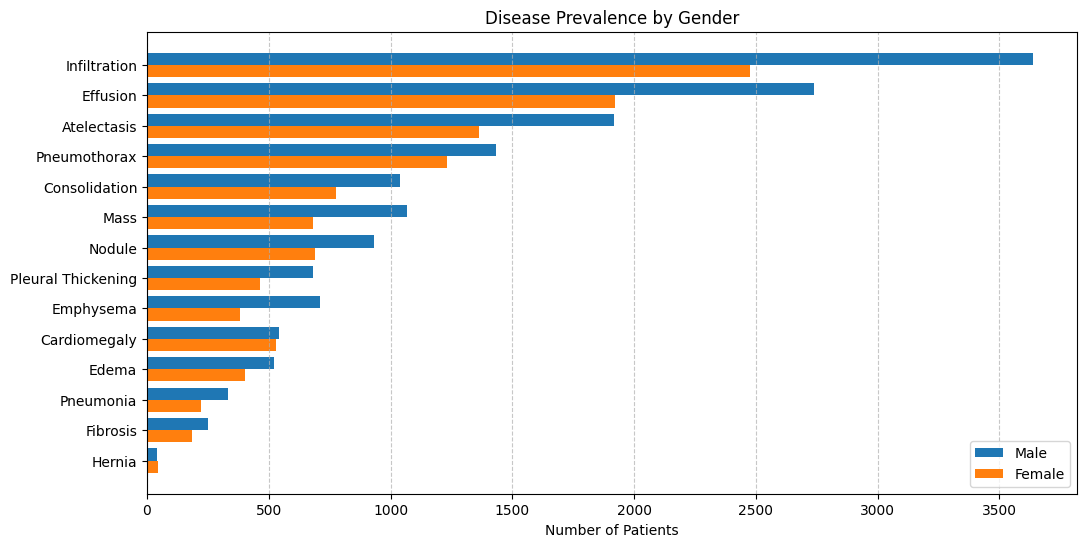

In [130]:


# ---- Count occurrences per gender ----
male_counts = Counter()
female_counts = Counter()

# Disease names (excluding "No Finding")
disease_names = [
    "Hernia", "Emphysema", "Nodule", "Pneumonia", "Consolidation",
    "Cardiomegaly", "Effusion", "Mass", "Pleural Thickening", "Atelectasis",
    "Pneumothorax", "Fibrosis", "Infiltration", "Edema"
]

for i in range(len(ds["findings"])):
    findings = ds["findings"][i].numpy()
    gender = ds["metadata/patient_gender"][i].numpy()

    for disease in findings:
        if disease != 0:  # Ignore "No Finding"
            if gender == 1:
                male_counts[disease - 1] += 1  # Adjust index (1-based to 0-based)
            else:
                female_counts[disease - 1] += 1  # Adjust index

# Sort diseases by prevalence (descending order)
sorted_diseases = sorted(male_counts.keys(), key=lambda d: male_counts[d] + female_counts[d], reverse=True)

# Extract values for plotting
sorted_labels = [disease_names[d] for d in sorted_diseases]  # Use adjusted index
male_values = [male_counts[d] for d in sorted_diseases]
female_values = [female_counts[d] for d in sorted_diseases]

# ---- Bar Plot ----
x = np.arange(len(sorted_labels))
width = 0.4

plt.figure(figsize=(12, 6))
plt.barh(x - width/2, male_values, width, label="Male", color="#1f77b4")
plt.barh(x + width/2, female_values, width, label="Female", color="#ff7f0e")

# Formatting
plt.yticks(x, sorted_labels)
plt.xlabel("Number of Patients")
plt.title("Disease Prevalence by Gender")
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


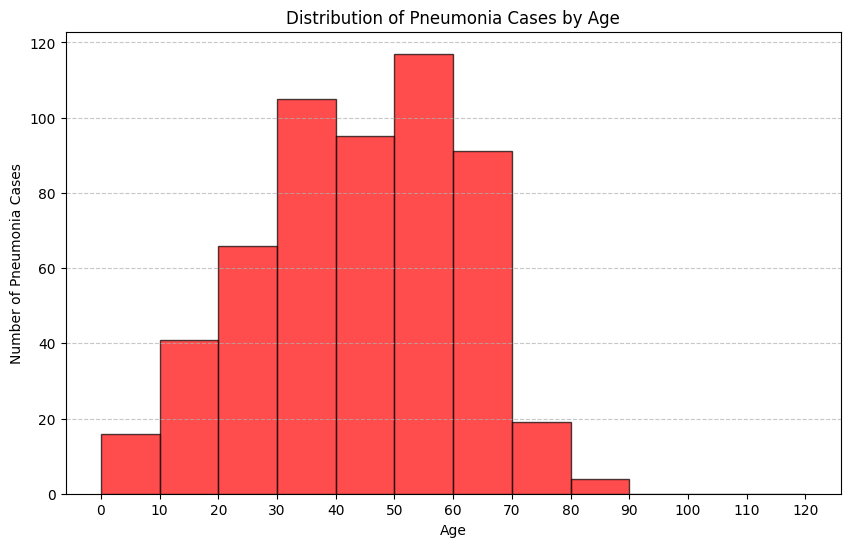

ValueError: Per-column arrays must each be 1-dimensional

<Figure size 600x600 with 0 Axes>

In [ ]:
# Define age bins (e.g., group ages into 10-year intervals)
bins = range(0, 121, 10)  # 0-10, 11-20, ..., 111-120
plt.figure(figsize=(10, 6))


pneumonia_ages = []

# Extract ages for patients with pneumonia
for i in range(len(ds["findings"])):
    findings = ds["findings"][i].numpy()
    age = ds["metadata/patient_age"][i].numpy()

    if 0 < age < 120 and 4 in findings:  # Ensure valid age & pneumonia (assuming 4 = Pneumonia)
        pneumonia_ages.append(age)

# Convert to a proper 1D array
pneumonia_ages = np.array(pneumonia_ages).flatten()

# Plot histogram
plt.hist(pneumonia_ages, bins=bins, edgecolor="black", alpha=0.7, color="red")

# Formatting
plt.xlabel("Age")
plt.ylabel("Number of Pneumonia Cases")
plt.title("Distribution of Pneumonia Cases by Age")
plt.xticks(bins)  # Show bin edges on x-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# ---- Box Plot ----
plt.figure(figsize=(6, 6))
sns.boxplot(y=pneumonia_ages, color="red")

# Formatting
plt.ylabel("Age")
plt.title("Age Distribution of Pneumonia Cases")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
